<a href="https://colab.research.google.com/github/rawa-elargab/Lyft-Demand-for-Bike/blob/main/demand_for_bike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About Dataset
**Description:**
Lyft, Inc. is a transportation network company based in San Francisco, California and operating in 640 cities in the United States and 9 cities in Canada. It develops, markets, and operates the Lyft mobile app, offering car rides, scooters, and a bicycle-sharing system. It is the second largest rideshare company in the world, second to only Uber.
Lyft’s bike-sharing service is also among the largest in the USA. Being able to anticipate demand is extremely important for planning of bicycles, stations, and the personnel required to maintain these. This demand is sensitive to a lot of factors like season, humidity, rain, weekdays, holidays, and more. To enable this planning, Lyft needs to rightly predict the demand according to these factors

**Data Description:**
The variables present in the dataset are:

- instant: Serial number
- dteday: date and day
- hour: hour of the day (0 to 23)
- season: season (1:spring, 2:summer, 3:fall, 4:winter)
- yr: year (0: 2011, 1: 2012)
- mnth: month (1 to 12)
- hr: hour (0 to 23)
- holiday: whether the day is a holiday or not
- weekday: day of the week, Monday=0, Sunday=6.
- workingday: if the day is neither weekend nor a holiday is 1, otherwise is 0
- weathersit: four categories (1 to 4) ranging from best to worst weather
- temp: normalized temperature in Celsius; the values are divided to 41 (max)
- atemp: normalized temperature felt in Celsius; the values are divided to 50(max)
- hum: normalized humidity; the values are divided to 100 (max)
- windspeed: normalized wind speed; the values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: The demand of bikes

# Imports and reading data

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('/content/Lyftdataset.csv')

In [3]:
df.head(5)

instant    dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  01-01-11       1   0     1   0        0        6           0   
1        2  01-01-11       1   0     1   1        0        6           0   
2        3  01-01-11       1   0     1   2        0        6           0   
3        4  01-01-11       1   0     1   3        0        6           0   
4        5  01-01-11       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

# Understanding data

In [4]:
df.shape

(17379, 17)

In [5]:
# Information on data types and count
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [6]:
df.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

In [7]:
# Description of the data in basic statistics
df.describe().T 

count         mean          std   min        25%        50%  \
instant     17379.0  8690.000000  5017.029500  1.00  4345.5000  8690.0000   
season      17379.0     2.501640     1.106918  1.00     2.0000     3.0000   
yr          17379.0     0.502561     0.500008  0.00     0.0000     1.0000   
mnth        17379.0     6.537775     3.438776  1.00     4.0000     7.0000   
hr          17379.0    11.546752     6.914405  0.00     6.0000    12.0000   
holiday     17379.0     0.028770     0.167165  0.00     0.0000     0.0000   
weekday     17379.0     3.003683     2.005771  0.00     1.0000     3.0000   
workingday  17379.0     0.682721     0.465431  0.00     0.0000     1.0000   
weathersit  17379.0     1.425283     0.639357  1.00     1.0000     1.0000   
temp        17379.0     0.496987     0.192556  0.02     0.3400     0.5000   
atemp       17379.0     0.475775     0.171850  0.00     0.3333     0.4848   
hum         17379.0     0.627229     0.192930  0.00     0.4800     0.6300   
windspeed   17379.0     0.190098     0.122340  0.00     0.1045     0.1940   
casual      17379.0    35.676218    49.305030  0.00     4.0000    17.0000   
registered  17379.0   153.786869   151.357286  0.00    34.0000   115.0000   
cnt         17379.0   189.463088   181.387599  1.00    40.0000   142.0000   

                   75%         max  
instant     13034.5000  17379.0000  
season          3.0000      4.0000  
yr              1.0000      1.0000  
mnth           10.0000     12.0000  
hr             18.0000     23.0000  
holiday         0.0000      1.0000  
weekday         5.0000      6.0000  
workingday      1.0000      1.0000  
weathersit      2.0000      4.0000  
temp            0.6600      1.0000  
atemp           0.6212      1.0000  
hum             0.7800      1.0000  
windspeed       0.2537      0.8507  
casual         48.0000    367.0000  
registered    220.0000    886.0000  
cnt           281.0000    977.0000

# Data preparation

In [8]:
# To see for missing values, no missing values
df.isna().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [9]:
# No duplicate records found
df.duplicated().sum()

0

In [10]:
# Renaming columns for consistency and readability
df.rename(columns={'dteday':'date',
                  'yr':'year',
                  'mnth':'month',
                  'hr':'hour',
                  'weathersit':'weather',
                  'hum':'humidity',
                  'cnt':'count'}, inplace=True)

In [11]:
# Dropping irrelevent columns 
df.drop(['instant','casual','registered'], axis=1, inplace=True)

In [12]:
# Season, weather and year dictionary
seasons = {
    1:'spring',
    2:'summer',
    3:'fall',
    4:'winter'
}

weathers = {
    1:'best',
    2:'better',
    3:'good',
    4:'worst'
}

years = {
    0:2011,
    1:2012
    }

In [13]:
df['season'] = df['season'].map(lambda x: seasons[x])
df['weather'] = df['weather'].map(lambda x: weathers[x])
df['year'] = df['year'].map(lambda x: years[x])

In [14]:
# Creating index 
df['date'] = df['date'] +' '+ df['hour'].astype(str)
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%y %H')

df.set_index(df['date'], inplace=True)
df.drop(['date'], axis=1, inplace=True)

In [15]:
# Feature creation
df['dayofmonth'] = df.index.day
df['quarter'] = df.index.quarter
df['weekofyear'] = df.index.weekofyear
df['dayofyear'] = df.index.dayofyear

<ipython-input-15-d9f5b0280f7a>:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['weekofyear'] = df.index.weekofyear


In [16]:
# making the column values back to original
df.temp = df.temp * 41
df.atemp = df.atemp * 50
df.humidity = df.humidity * 100
df.windspeed = df.windspeed * 67

# Feature understanding

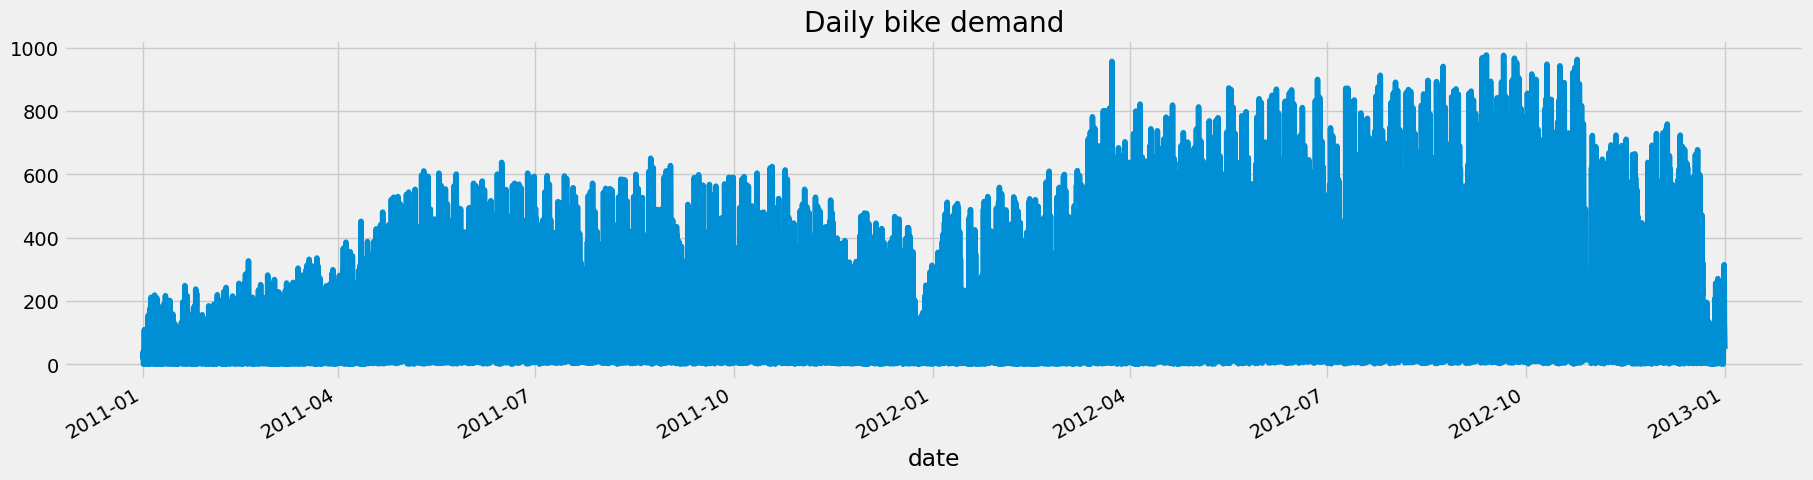

In [17]:
_ = df['count'].plot(style='-', figsize=(20,5), title='Daily bike demand')

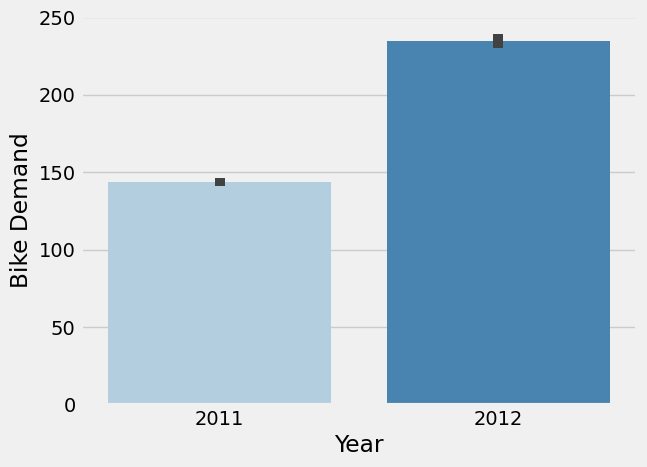

In [18]:
# plot of year vs. bike demand
ax = sns.barplot(x='year', y='count', data=df, palette='Blues')
ax.set_xlabel('Year')
ax.set_ylabel('Bike Demand')
plt.show()

- Huge demand increase from 2011 to 2012

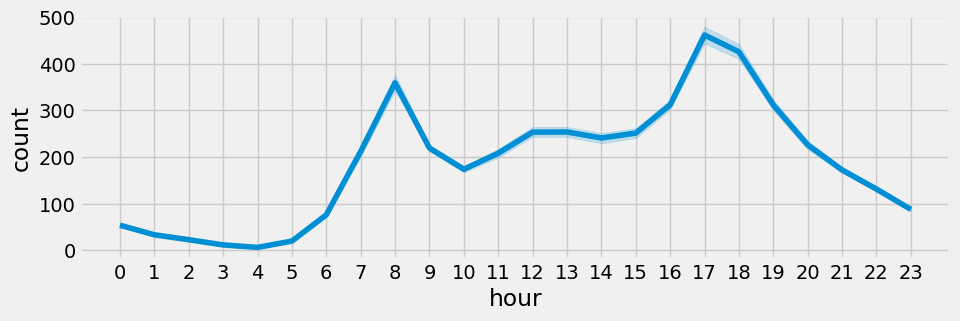

In [19]:
# plot of hour vs. bike demand
plt.figure(figsize=(10,3))
ax = sns.lineplot(x='hour', y='count', data=df.reset_index())
ax.set_xticks(df['hour'].unique())
plt.show()

- Bike demand is high in morning at 8 AM and higest of the day at 5 PM.

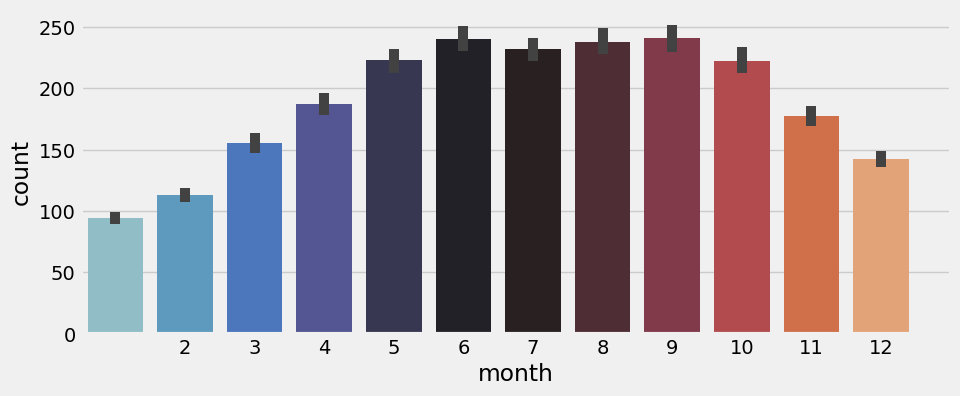

In [20]:
# plot of month vs. bike demand
plt.figure(figsize=(10,4))
ax = sns.barplot(x='month', y='count', data=df, palette='icefire')
ax.set_xticks(df['month'].unique())
plt.show()

- Demand is higest in the month of June, July, August and September.

<ipython-input-21-4073e962a545>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  _ = sns.barplot(x='weekday', y='count', data=df, ci=None, palette='viridis')


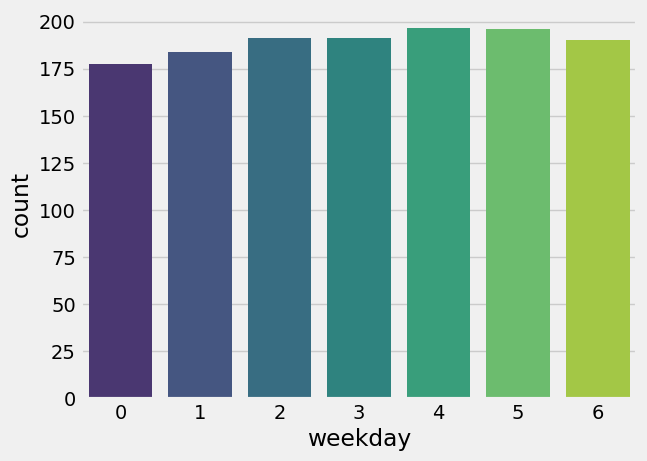

In [21]:
# Plot between weekday vs. count
_ = sns.barplot(x='weekday', y='count', data=df, ci=None, palette='viridis')

- Demand increase towards weeked and reaches max on Friday and Saturday.

<ipython-input-22-43330dbe605b>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='dayofmonth', y='count', data=df, ci=None, palette='flare')


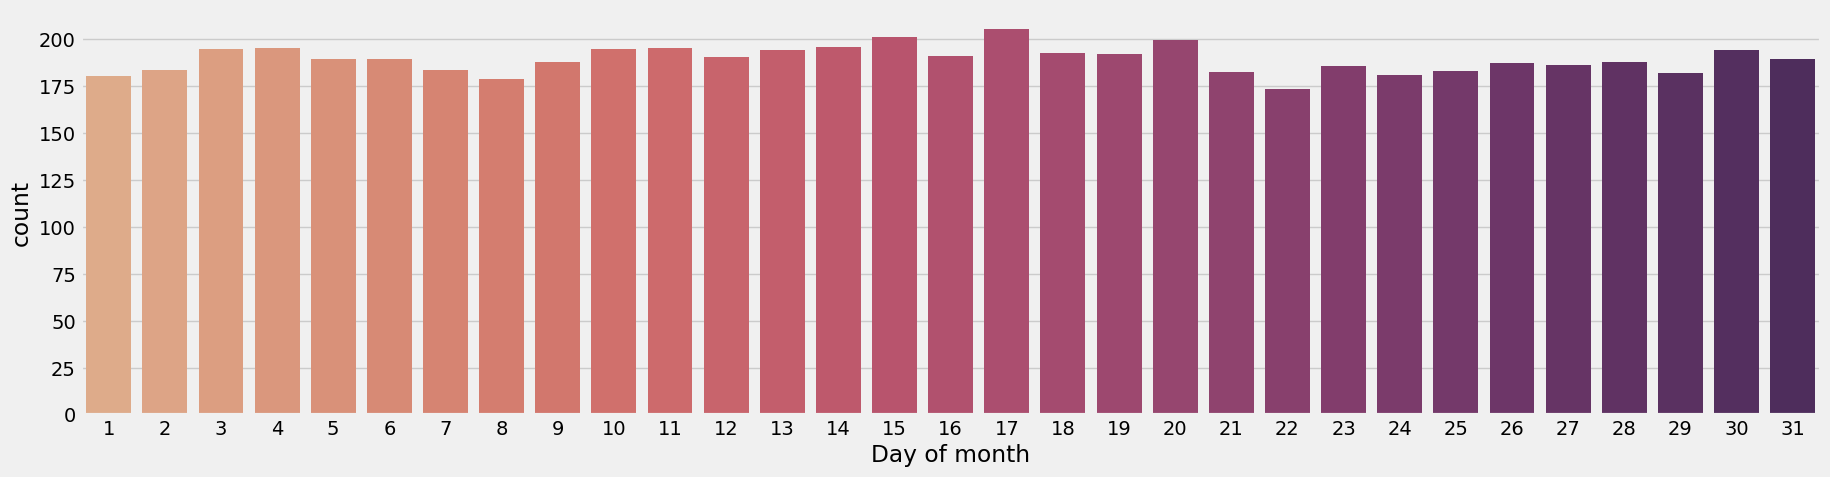

In [22]:
# plot of month of day vs. count
plt.figure(figsize=(20,5))
ax = sns.barplot(x='dayofmonth', y='count', data=df, ci=None, palette='flare')
ax.set_xlabel('Day of month')
plt.show()

- Day 5th to 10th showing high demand.

<ipython-input-23-a6960eae6b72>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='season', y='count', data=df, ci=None, ax=ax1)
<ipython-input-23-a6960eae6b72>:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='weather', y='count', data=df.reset_index(), ci=None, ax=ax2, color='purple')


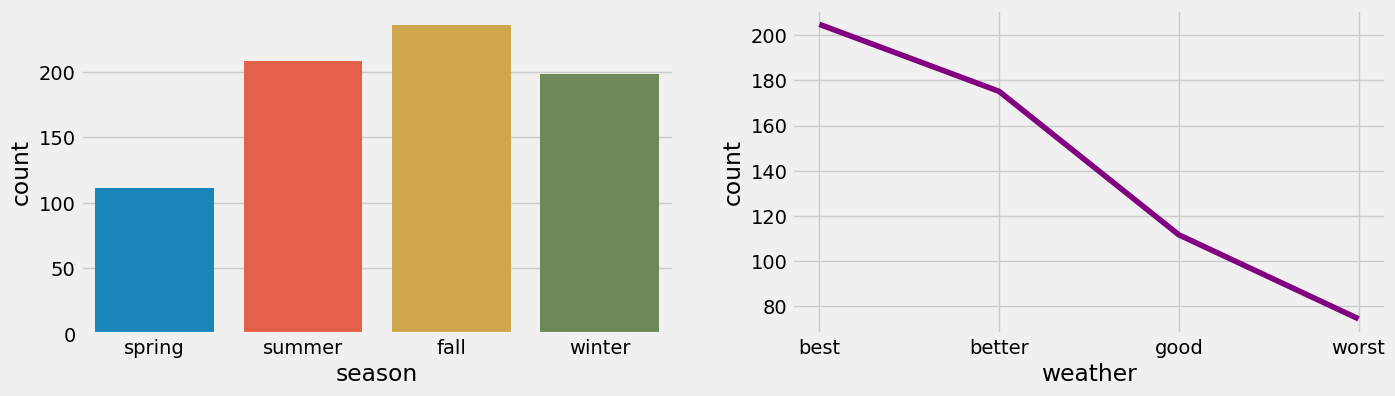

In [23]:
# plot for season vs. demand and weather condition vs. demand
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
sns.barplot(x='season', y='count', data=df, ci=None, ax=ax1)
sns.lineplot(x='weather', y='count', data=df.reset_index(), ci=None, ax=ax2, color='purple')
plt.show()

- Fall season has higest demand.
- Also, Obviously Best weather has higest demand.

<ipython-input-24-971fa33c5630>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='holiday', y='count', data=df, ci=None, ax=ax1, estimator=sum)
<ipython-input-24-971fa33c5630>:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='workingday', y='count', data=df, ci=None, ax=ax2, palette='dark:salmon', estimator=sum)


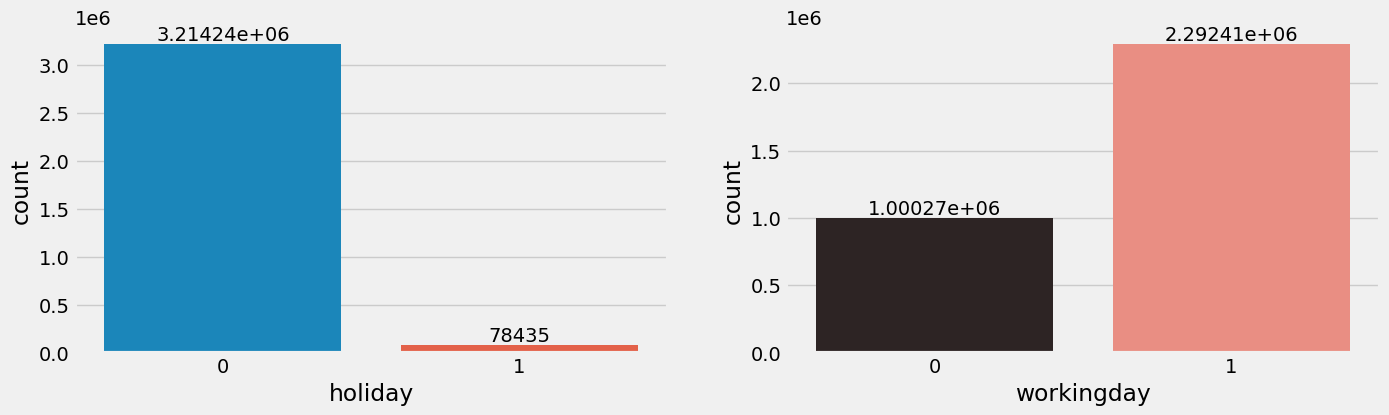

In [24]:
# Plot showing relation between holiday vs. count and workingday vs. count
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
sns.barplot(x='holiday', y='count', data=df, ci=None, ax=ax1, estimator=sum)
sns.barplot(x='workingday', y='count', data=df, ci=None, ax=ax2, palette='dark:salmon', estimator=sum)
ax1.bar_label(ax1.containers[0])
ax2.bar_label(ax2.containers[0])
plt.show()

- Non-holiday and working day has higest demand.

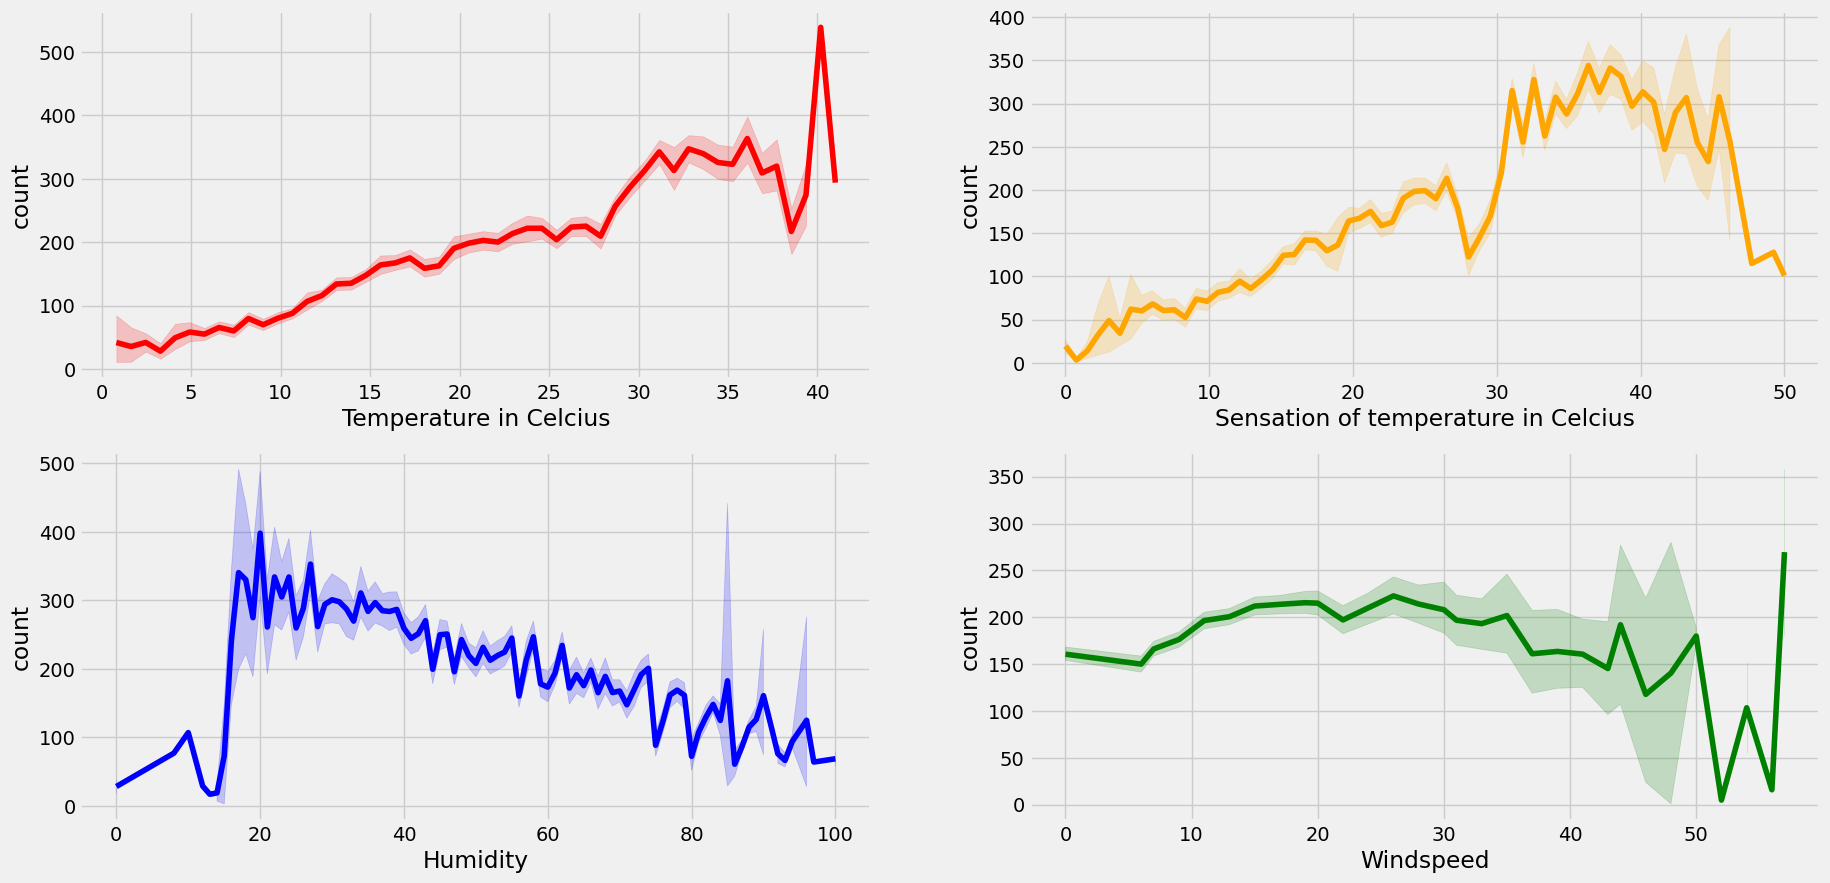

In [25]:
f, ax = plt.subplots(2, 2, figsize=(20,10))
sns.lineplot(x='temp', y='count', data=df.reset_index(), ax=ax[0][0], color='red')
sns.lineplot(x='atemp', y='count', data=df.reset_index(), ax=ax[0][1], color='orange')
sns.lineplot(x='humidity', y='count', data=df.reset_index(), ax=ax[1][0], color='blue')
sns.lineplot(x='windspeed', y='count', data=df.reset_index(), ax=ax[1][1], color='green')
ax[0][0].set_xlabel('Temperature in Celcius')
ax[0][1].set_xlabel('Sensation of temperature in Celcius')
ax[1][0].set_xlabel('Humidity')
ax[1][1].set_xlabel('Windspeed')
plt.show()

- When temperature feels between 30 and 40, humidity around 20 and windspeed between 20 and 30 showing higher demand.

# Feature relationship

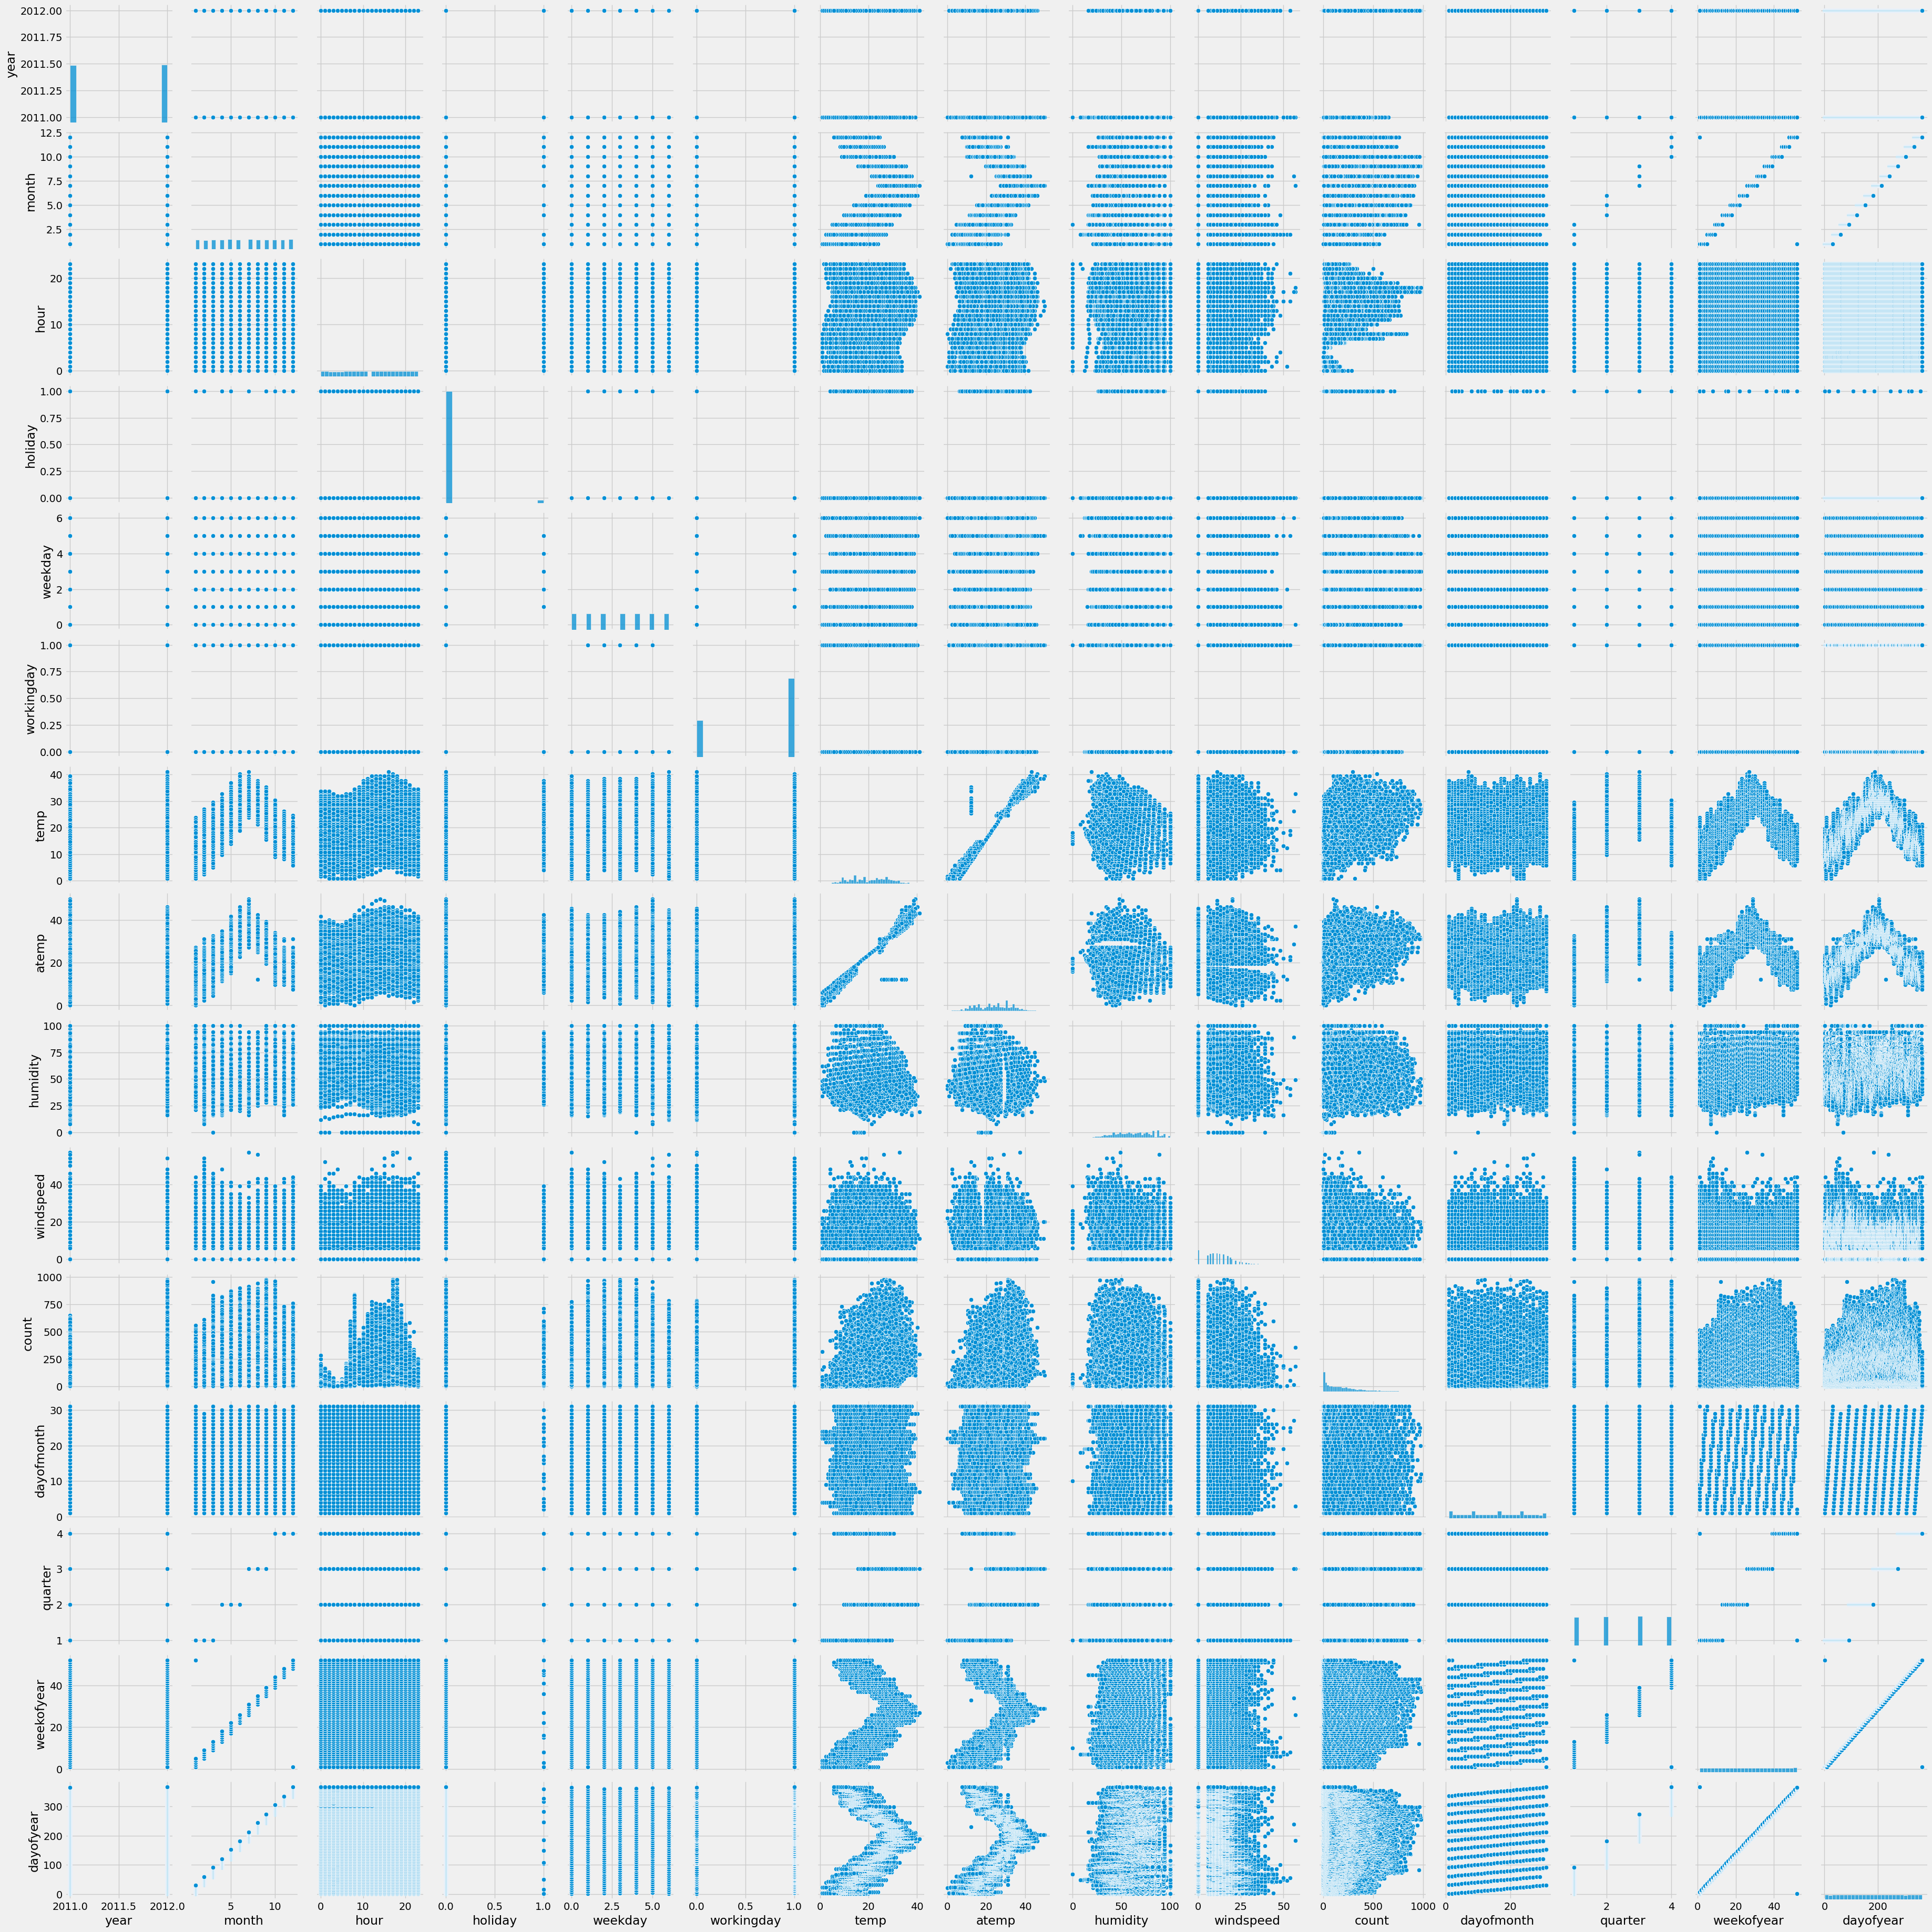

In [26]:
# Showing relationship between variables using pair plot
_ = sns.pairplot(data=df.reset_index())

<ipython-input-27-34ba1d9228dc>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  _ = sns.heatmap(df.corr(), annot=True)


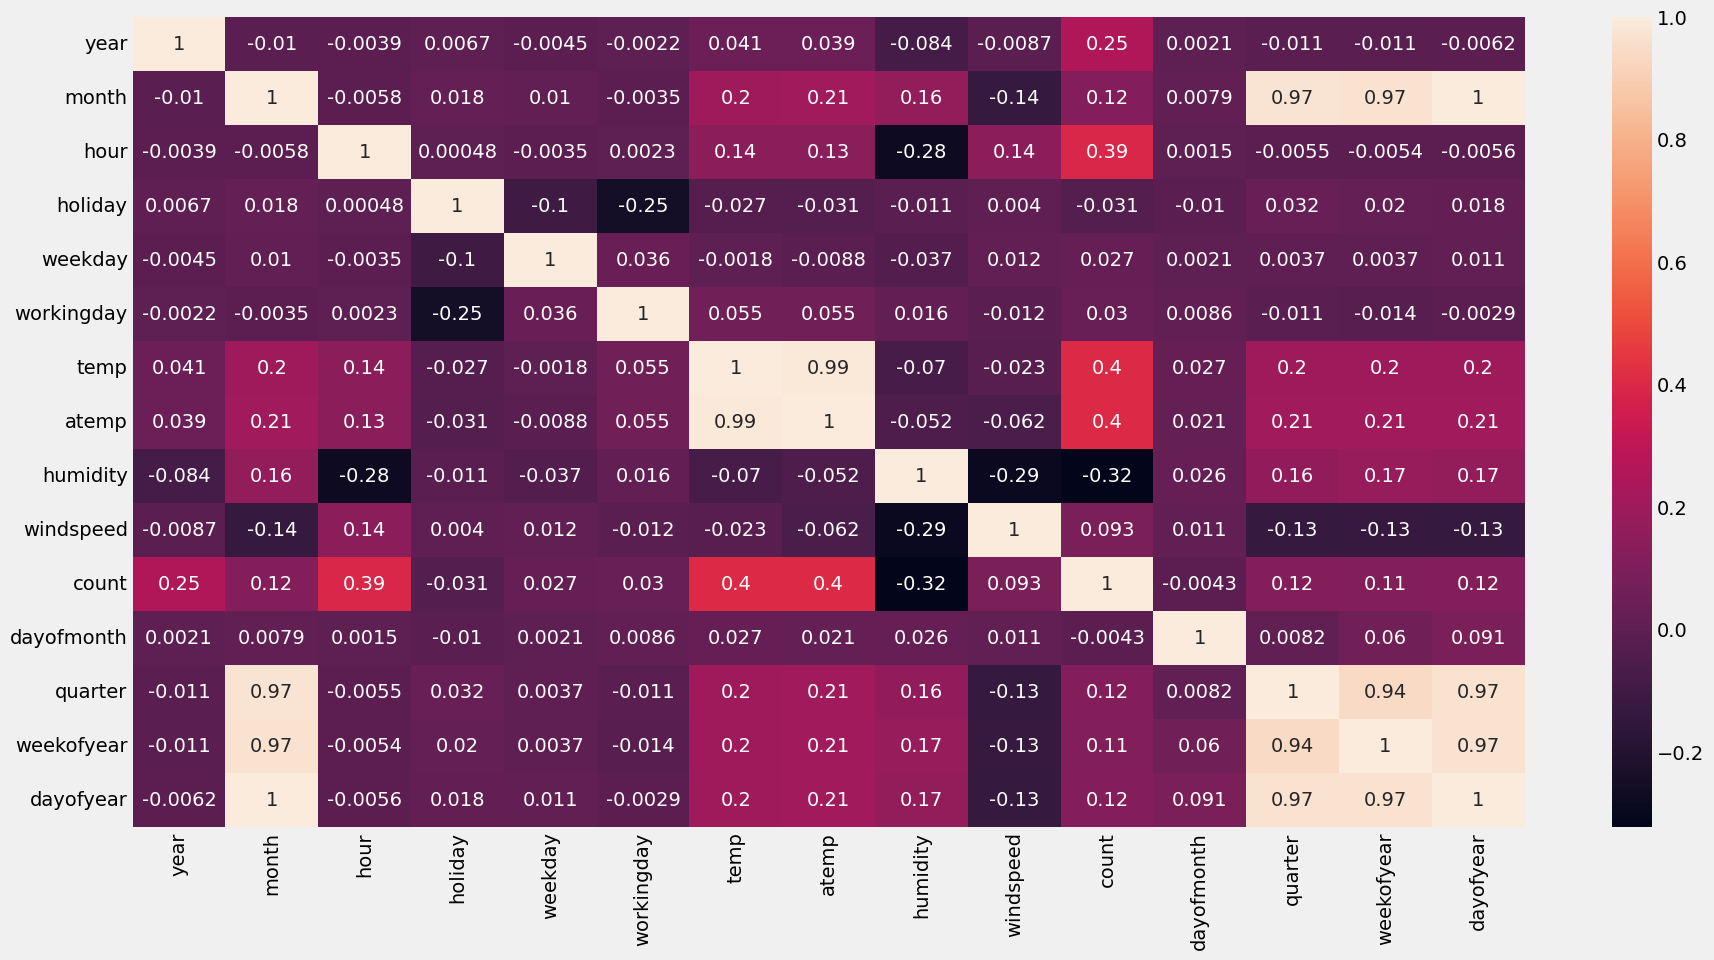

In [27]:
# Correlation between features
plt.figure(figsize=(20,10))
_ = sns.heatmap(df.corr(), annot=True)

- From heatmap correlation, temp and atemp showing very high corelation.

# Feature selection 

In [28]:
df.sample(2)

season  year  month  hour  holiday  weekday  workingday  \
date                                                                           
2011-11-14 12:00:00  winter  2011     11    12        0        1           1   
2012-10-21 03:00:00  winter  2012     10     3        0        0           0   

                    weather   temp   atemp  humidity  windspeed  count  \
date                                                                     
2011-11-14 12:00:00    best  22.96  26.515      56.0    19.9995    202   
2012-10-21 03:00:00    best  15.58  19.695      66.0     6.0032     41   

                     dayofmonth  quarter  weekofyear  dayofyear  
date                                                             
2011-11-14 12:00:00          14        4          46        318  
2012-10-21 03:00:00          21        4          42        295

In [29]:
# Calculate the VIF and selection the feature with low VIF
cols_for_vif = ['month', 'hour', 'holiday','weekday', 'workingday', 'temp', 'humidity', 'windspeed','dayofmonth','weekofyear',]
X = df[cols_for_vif]
df_vif = pd.DataFrame()
df_vif['feature'] = X.columns
df_vif['value'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
df_vif.sort_values(by='value', ascending=False)

feature      value
0       month  71.347440
9  weekofyear  64.959566
6    humidity   7.487488
5        temp   7.173155
8  dayofmonth   4.066716
1        hour   3.703236
4  workingday   3.233663
7   windspeed   3.132051
3     weekday   3.067796
2     holiday   1.094882

# Feature engineering

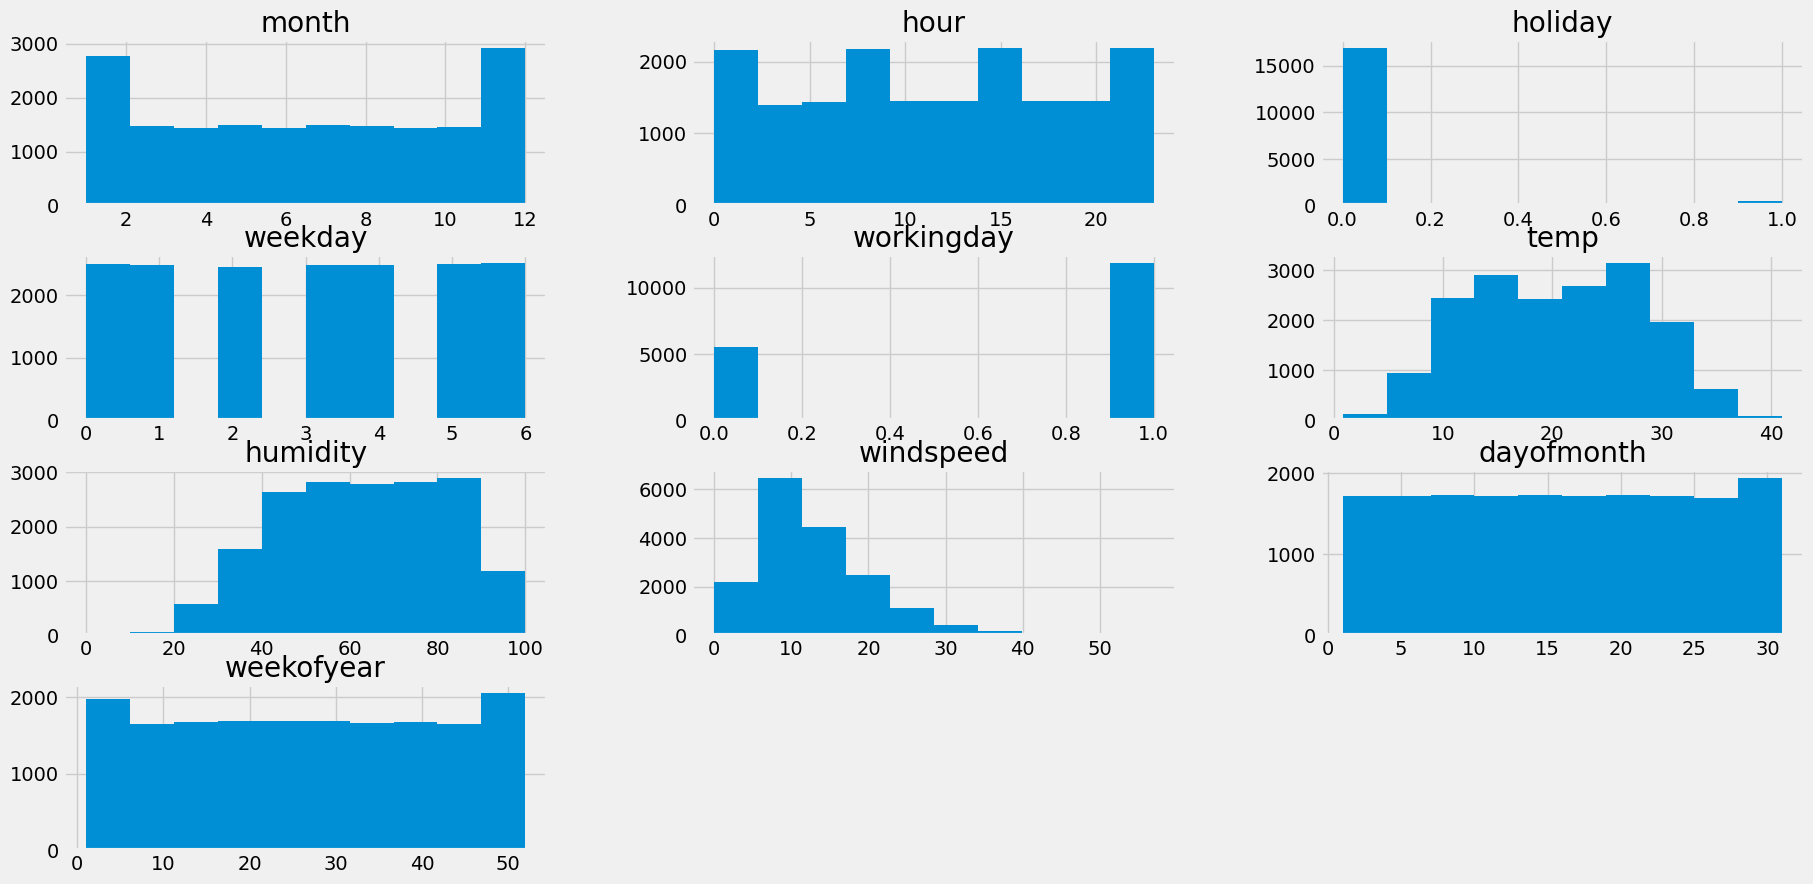

In [30]:
# Overview of data distribution
_ = df[cols_for_vif].hist(figsize=(20,10))

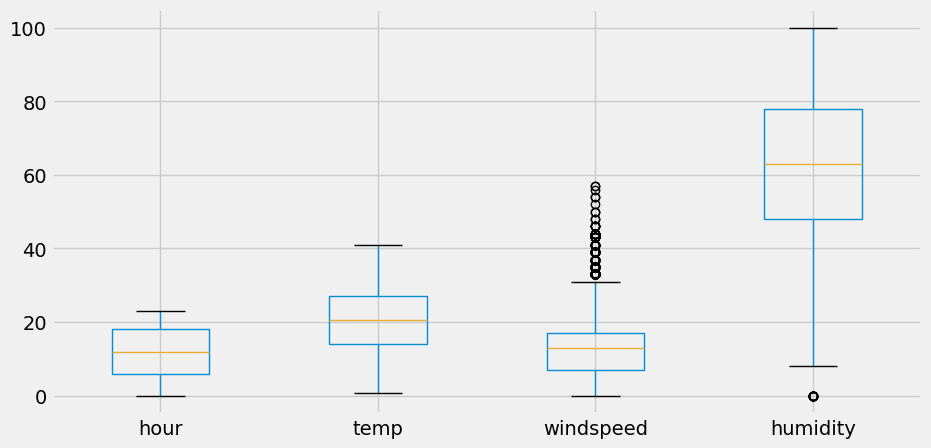

In [31]:
# To check the presence of outliers
_ = df[['hour','temp','windspeed','humidity']].boxplot(figsize=(10,5))

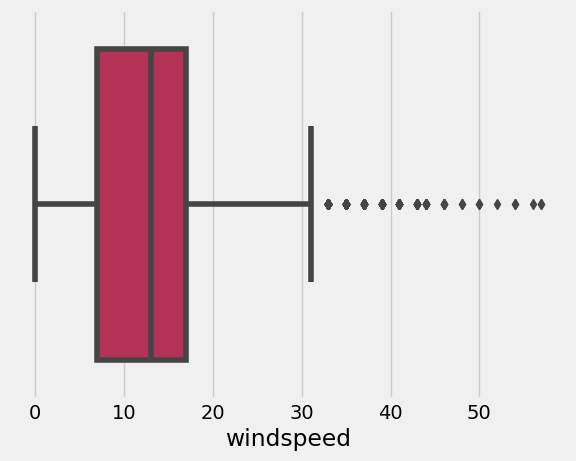

In [32]:
# Presence of outliers in windspeed feature
_ = sns.boxplot(data=df, x='windspeed', palette='rocket')

In [33]:
# Splitting into training and validation dataset

df_train = df.loc[df.index < '2012-07-01']
df_valid = df.loc[df.index >= '2012-07-01']

feature_to_train = ['month', 'hour', 'holiday','weekday', 'workingday', 'temp', 'humidity', 'windspeed','dayofmonth','season','weather',
                   'weekofyear','year']
X_train = df_train[feature_to_train]
X_valid = df_valid[feature_to_train]

y_train = df_train['count']
y_valid = df_valid['count']

In [34]:
# Performing OneHotEncoding on non-ordinal features
ohe_pipe = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_train_ohe = pd.DataFrame(ohe_pipe.fit_transform(X_train[['season']]))
X_valid_ohe = pd.DataFrame(ohe_pipe.transform(X_valid[['season']]))

X_train_ohe.columns = ohe_pipe.get_feature_names_out()
X_train_ohe.index = X_train.index

X_valid_ohe.columns = ohe_pipe.get_feature_names_out()
X_valid_ohe.index = X_valid.index

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [35]:
# Performing OrdinalEncoding on ordinal features
oe_pipe = OrdinalEncoder(categories=[['good', 'better', 'best', 'worst']], handle_unknown='error')
X_train_oe = pd.DataFrame(oe_pipe.fit_transform(X_train[['weather']]))
X_valid_oe = pd.DataFrame(oe_pipe.transform(X_valid[['weather']]))

X_train_oe.columns = oe_pipe.feature_names_in_
X_valid_oe.columns = oe_pipe.feature_names_in_

X_train_oe.index = X_train.index
X_valid_oe.index = X_valid.index

In [36]:
X_train.drop(['season','weather'], axis=1, inplace=True)
X_valid.drop(['season','weather'], axis=1, inplace=True)

<ipython-input-36-bc8a7c22b0ce>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(['season','weather'], axis=1, inplace=True)
<ipython-input-36-bc8a7c22b0ce>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid.drop(['season','weather'], axis=1, inplace=True)


In [37]:
X_train = pd.concat([X_train, X_train_ohe, X_train_oe], axis=1)
X_valid = pd.concat([X_valid, X_valid_ohe, X_valid_oe], axis=1)

# Model training

In [38]:
# Dictionary of estimators
estimators = { 'LinearRegression' : LinearRegression(n_jobs=-1),
               'RandomForestRegressor': RandomForestRegressor(),
               'GradientBoostingRegressor': GradientBoostingRegressor(),
               'SVR': SVR(),
               'KNeighborsRegressor': KNeighborsRegressor(),
               'XGBRegressor': xgb.XGBRegressor()
             }

In [39]:
def get_prediction(estimators):
    """Train the models and get the score"""
    for name, model in estimators.items():
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_valid)
        y_train_pred = model.predict(X_train)
        
        print(f'Train MAE: {name}  {mean_absolute_error(y_train, y_train_pred)}')
        print(f'Train MSE: {name}  {mean_squared_error(y_train, y_train_pred)}')
        print(f'Train R2: {name}  {r2_score(y_train, y_train_pred)}')

        print(30*'*')

        print(f'Val MAE: {name}  {mean_absolute_error(y_valid, y_pred)}')
        print(f'Val MSE: {name}  {mean_squared_error(y_valid, y_pred)}')
        print(f'Val R2: {name}  {r2_score(y_valid, y_pred)}')
        
        print(60*'#', end='\n')

In [40]:
# Getting score form different models
get_prediction(estimators)

Train MAE: LinearRegression  93.23199195656632
Train MSE: LinearRegression  15501.078747016865
Train R2: LinearRegression  0.40034477063779783
******************************
Val MAE: LinearRegression  138.6700996788178
Val MSE: LinearRegression  33511.60472534503
Val R2: LinearRegression  0.30566888136232195
############################################################
Train MAE: RandomForestRegressor  8.19838883334615
Train MSE: RandomForestRegressor  188.13195974005998
Train R2: RandomForestRegressor  0.9927221637081227
******************************
Val MAE: RandomForestRegressor  50.24697669104205
Val MSE: RandomForestRegressor  5864.6253598948815
Val R2: RandomForestRegressor  0.8784900955982261
############################################################
Train MAE: GradientBoostingRegressor  42.238522932666065
Train MSE: GradientBoostingRegressor  3786.676480067809
Train R2: GradientBoostingRegressor  0.8535133979877041
******************************
Val MAE: GradientBoostingRegre

- RandomForestRegressor and XGBRegressor gave the best result.

In [41]:
X_train.head(3)

month  hour  holiday  weekday  workingday  temp  \
date                                                                   
2011-01-01 00:00:00      1     0        0        6           0  9.84   
2011-01-01 01:00:00      1     1        0        6           0  9.02   
2011-01-01 02:00:00      1     2        0        6           0  9.02   

                     humidity  windspeed  dayofmonth  weekofyear  year  \
date                                                                     
2011-01-01 00:00:00      81.0        0.0           1          52  2011   
2011-01-01 01:00:00      80.0        0.0           1          52  2011   
2011-01-01 02:00:00      80.0        0.0           1          52  2011   

                     season_fall  season_spring  season_summer  season_winter  \
date                                                                            
2011-01-01 00:00:00          0.0            1.0            0.0            0.0   
2011-01-01 01:00:00          0.0            1.0            0.0            0.0   
2011-01-01 02:00:00          0.0            1.0            0.0            0.0   

                     weather  
date                          
2011-01-01 00:00:00      2.0  
2011-01-01 01:00:00      2.0  
2011-01-01 02:00:00      2.0

In [42]:
# XGBRegressor
xgbr = xgb.XGBRegressor(n_estimators=500,
                        early_stopping_rounds=5,
                        learning_rate=0.2)
xgbr.fit(X_train, y_train, 
         eval_set=[(X_train, y_train),(X_valid, y_valid)], 
         verbose=50)

[0]	validation_0-rmse:193.25706	validation_1-rmse:285.07570
[50]	validation_0-rmse:30.53748	validation_1-rmse:70.23819
[54]	validation_0-rmse:30.20710	validation_1-rmse:70.33805


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

# Model Evaluation

In [43]:
df_valid['pred'] = xgbr.predict(X_valid)
y_pred = xgbr.predict(X_valid)
y_train_pred = xgbr.predict(X_train)

print(f'Train MAE: {mean_absolute_error(y_train, y_train_pred):.2f}')
print(f'Train MSE: {mean_squared_error(y_train, y_train_pred):.2f}')
print(f'Train R2: {r2_score(y_train, y_train_pred):.2f}')

print(30*'*')

print(f'Val MAE: {mean_absolute_error(y_valid, y_pred):.2f}')
print(f'Val MSE: {mean_squared_error(y_valid, y_pred):.2f}')
print(f'Val R2: {r2_score(y_valid, y_pred):.2f}')

Train MAE: 19.84
Train MSE: 932.54
Train R2: 0.96
******************************
Val MAE: 46.37
Val MSE: 4933.40
Val R2: 0.90


<ipython-input-43-e68682006b70>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['pred'] = xgbr.predict(X_valid)


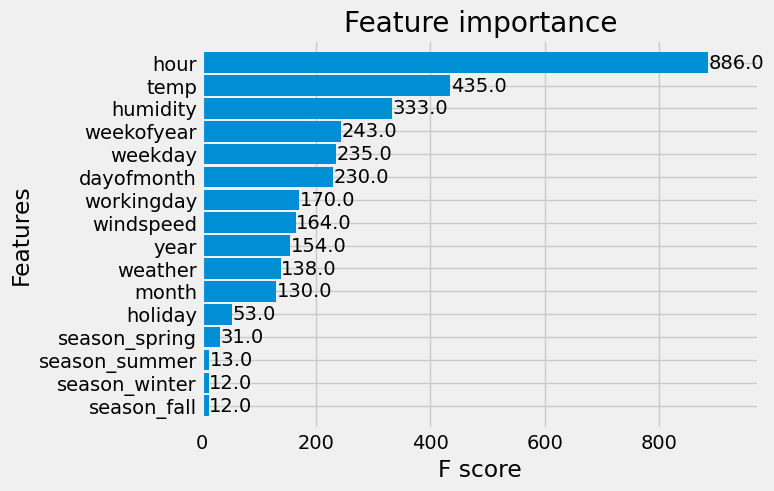

In [44]:
# Plotting feature importance
_ = plot_importance(xgbr, height=0.9)

# Cross validation

In [45]:
# Preparing data for cross validation
feature_to_train = ['month', 'hour', 'holiday','weekday', 'workingday', 'temp', 'humidity', 'windspeed','dayofmonth','season','weather',
                   'weekofyear','year']
X_train = df[feature_to_train]
y_train = df['count']

ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_train_ohe = pd.DataFrame(ohe.fit_transform(X_train[['season']]))
X_train_ohe.columns = ohe.get_feature_names_out()
X_train_ohe.index = X_train.index

oe = OrdinalEncoder(categories=[['good', 'better', 'best', 'worst']], handle_unknown='error')
X_train_oe = pd.DataFrame(oe.fit_transform(X_train[['weather']]))
X_train_oe.columns = oe.feature_names_in_
X_train_oe.index = X_train.index

X_train.drop(['season','weather'], axis=1, inplace=True)
X_train = pd.concat([X_train, X_train_ohe, X_train_oe], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-45-f10650946699>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(['season','weather'], axis=1, inplace=True)


In [46]:
# Testing score on cross validation
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=4)

for i, (tr_idx, val_idx) in enumerate(tss.split(X_train)):
    X_tr, y_tr = X_train.iloc[tr_idx], y_train.iloc[tr_idx]
    X_val, y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]
    
    model = xgb.XGBRegressor(n_estimators=500,
                        early_stopping_rounds=5,
                        learning_rate=0.2)
    model.fit(X_tr, y_tr, 
              eval_set=[(X_tr, y_tr),(X_val, y_val)],
              verbose=0)
    
    y_train_pred = xgbr.predict(X_tr)
    print(f'Train R2 Score for {i} : {r2_score(y_tr, y_train_pred):.2f}')
    
    y_pred = model.predict(X_val)
    print(f'Val R2 Score for {i} : {r2_score(y_val, y_pred):.2f}')
    
    print('#'*50)

Train R2 Score for 0 : 0.95
Val R2 Score for 0 : 0.88
##################################################
Train R2 Score for 1 : 0.96
Val R2 Score for 1 : 0.57
##################################################
Train R2 Score for 2 : 0.96
Val R2 Score for 2 : 0.86
##################################################
Train R2 Score for 3 : 0.96
Val R2 Score for 3 : 0.90
##################################################


# Forecast on validation set

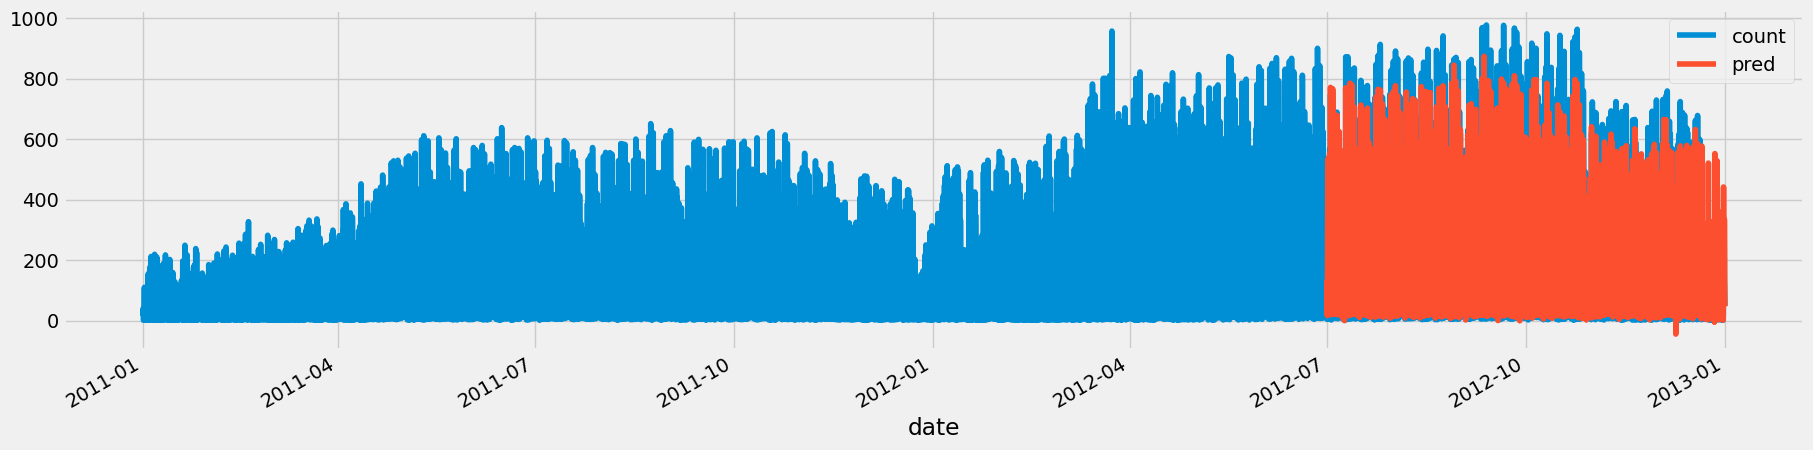

In [47]:
df_all = pd.concat([df_train,df_valid])
_ = df_all[['count','pred']].plot(figsize=(20,5))

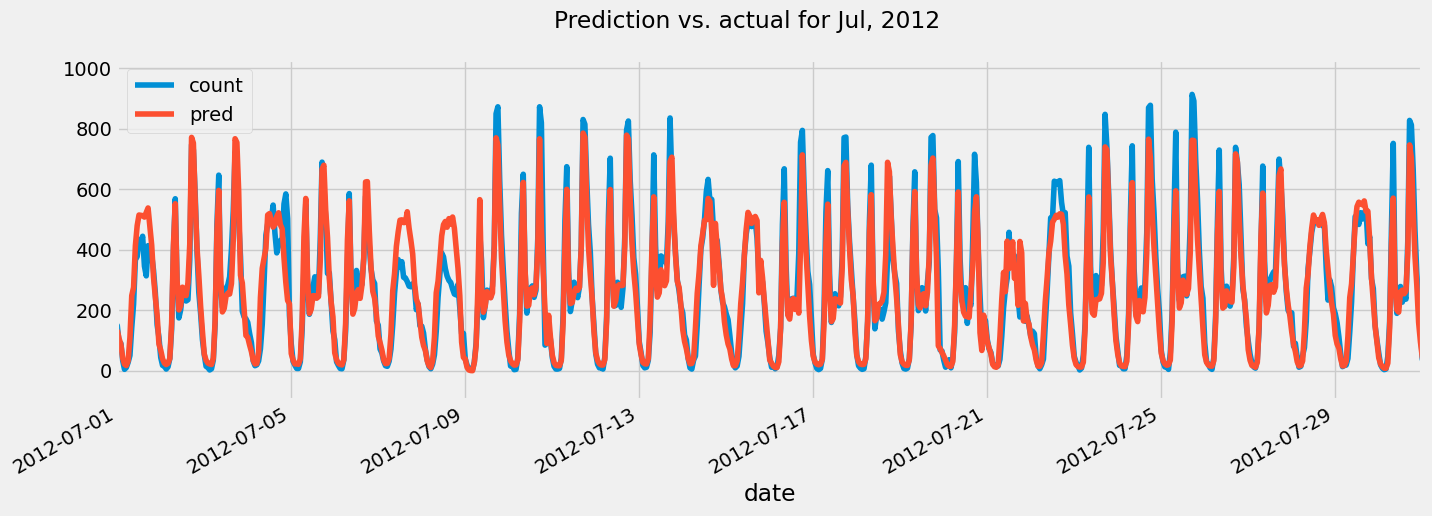

In [48]:
# plot the forcast with actual for first month i.e., July, 2012
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['count','pred']].plot(ax=ax, style=['-','-'])
ax.set_xbound(lower='01-Jul-2012', upper='31-Jul-2012')
_ = plt.suptitle('Prediction vs. actual for Jul, 2012')

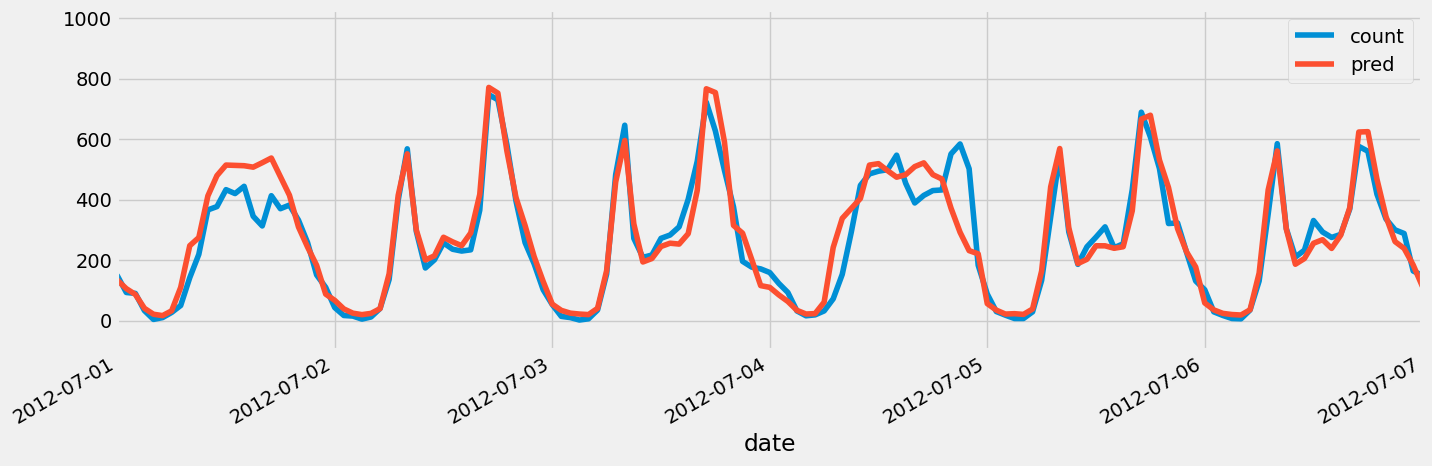

In [49]:
# plot the forcast for first week
f, ax = plt.subplots(1,figsize=(15,5))
df_all[['count', 'pred']].plot(ax=ax)
ax.set_xbound(lower='2012-07-01', upper='2012-07-07')
plt.show()

# Analysing the best and worst predicted days

In [50]:
df_all['error'] = df_all['count'] - df_all['pred']
df_all['abs_error'] = df_all['error'].apply(np.abs)

In [51]:
error_by_day = df_all.groupby(['year','month','dayofmonth'])[['count','pred','error','abs_error']].mean()

In [52]:
# Overforcasted days
error_by_day.sort_values(by='error').head(10)

count        pred      error  abs_error
year month dayofmonth                                              
2012 12    25           44.043478  136.166229 -92.122747  92.122747
           24           40.000000  122.306740 -82.306737  82.795183
     11    22          101.041667  179.242630 -78.200973  78.200973
     7     7           201.666667  277.710449 -76.043778  79.098571
     12    22           72.875000  143.532288 -70.657290  70.657290
     7     8           194.666667  265.056885 -70.390217  86.366726
     12    27           88.083333  154.205460 -66.122129  68.988670
           26           18.375000   82.228706 -63.853704  64.490929
     11    24           94.875000  158.041153 -63.166156  63.166156
     10    30           99.636364  157.677414 -58.041054  88.379051

In [53]:
# Worst predicted days
error_by_day.sort_values(by='abs_error', ascending=False).head(10)

count        pred      error   abs_error
year month dayofmonth                                               
2012 10    2           193.291667  160.537949  32.753723  103.798076
     11    23          162.916667  220.523392 -57.606720  101.651876
     12    25           44.043478  136.166229 -92.122747   92.122747
     10    30           99.636364  157.677414 -58.041054   88.379051
     7     8           194.666667  265.056885 -70.390217   86.366726
     12    24           40.000000  122.306740 -82.306737   82.795183
     7     7           201.666667  277.710449 -76.043778   79.098571
           4           308.458333  305.652100   2.806243   78.674334
     11    22          101.041667  179.242630 -78.200973   78.200973
     8     19          189.541667  240.919937 -51.378275   75.315272

In [54]:
# Best predicted days
error_by_day.sort_values(by='abs_error').head(10)

count        pred      error  abs_error
year month dayofmonth                                              
2012 10    29           22.000000   24.817930  -2.817930   2.817930
     7     2           259.458333  278.499115 -19.040795  22.197947
     8     18          327.708333  331.076202  -3.367865  23.437083
     12    15          210.291667  194.420349  15.871314  25.359366
     11    26          211.958333  201.411789  10.546557  26.111139
     8     28          293.333333  287.632904   5.700422  26.187636
           4           284.333333  294.717316 -10.383981  26.362890
     7     26          285.875000  264.476959  21.398060  27.533365
     10    14          276.625000  287.784576 -11.159595  28.017573
     12    19          219.458333  224.635193  -5.176858  28.405325

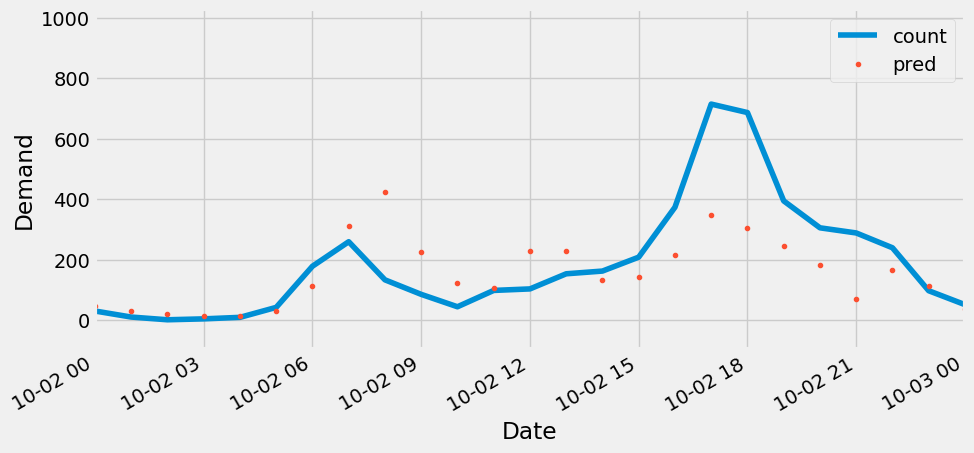

In [55]:
# Plotting worst predicted day
ax = df_all[['count','pred']].plot(style=['-','.'], figsize=(10,5))
ax.set_ylabel('Demand')
ax.set_xlabel('Date')
ax.set_xbound(lower='2012-10-02', upper='2012-10-03')
plt.show()

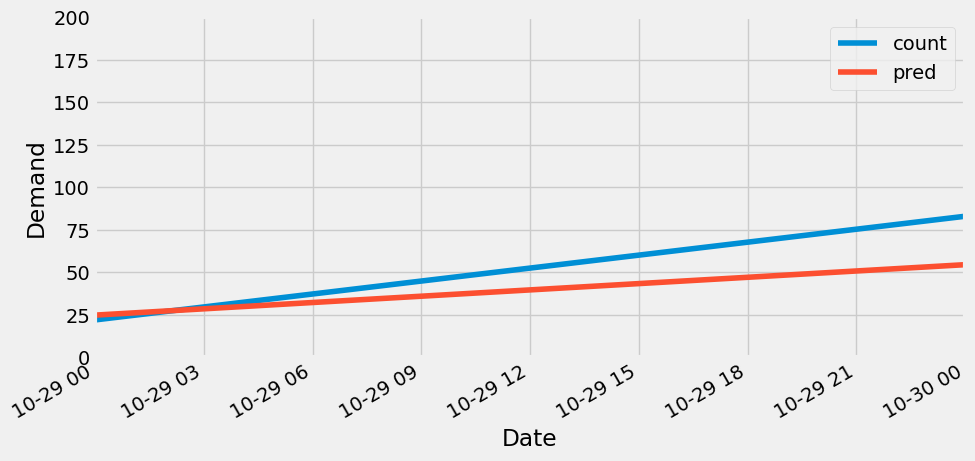

In [56]:
# Plotting best predicted day
ax = df_all[['count','pred']].plot(style=['-','-'], figsize=(10,5))
ax.set_xlabel('Date')
ax.set_ylabel('Demand')
ax.set_xbound(lower='2012-10-29', upper='2012-10-30')
ax.set_ylim(0,200)
plt.show()